### Loading Data, Data Preparation and Transformation

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import itertools
%matplotlib inline

In [2]:
DATA_DIR = "./"
DATA_FILENAMES = {"bluetooth": "bt_symmetric.csv",
                  "calls": "calls.csv",
                  "sms": "sms.csv",
                  "facebook_friends": "fb_friends.csv",
                  "genders": "genders.csv"}

In [3]:
def LoadData(data_filename, data_dir):
  '''Loads data from |data_dir|/|data_filename|. Returns Pandas dataframe.'''
  return pd.read_csv(os.path.join(data_dir, data_filename))  

In [4]:
df_bt = LoadData(DATA_FILENAMES["bluetooth"], DATA_DIR)
print("bluetooth\n", df_bt.head())

df_calls = LoadData(DATA_FILENAMES["calls"], DATA_DIR)
print("\ncalls\n", df_calls.head())

df_sms = LoadData(DATA_FILENAMES["sms"], DATA_DIR)
print("\nsms\n", df_sms.head())

df_facebook_friends = LoadData(DATA_FILENAMES["facebook_friends"], DATA_DIR)
print("\nfacebook friends\n", df_facebook_friends.head())

df_genders = LoadData(DATA_FILENAMES["genders"], DATA_DIR)
print("\ngenders\n", df_genders.head())

bluetooth
    # timestamp  user_a  user_b  rssi
0            0       0      -1     0
1            0       1      -1     0
2            0       2      -1     0
3            0       3      -2   -88
4            0       5      -1     0

calls
    timestamp  caller  callee  duration
0        184     300     301       121
1       3920     512     299       670
2       5623     301     300       504
3       9252     401     457        -1
4      15466     512       0         5

sms
    timestamp  sender  recipient
0         18     370        512
1         37     512        370
2        126     370        512
3        134       0        512
4        312     137        136

facebook friends
    # user_a  user_b
0         0     512
1         0     263
2         0     525
3         0     285
4         0     543

genders
    # user  female
0       0       0
1       2       0
2       3       0
3       4       0
4       5       0


In [5]:
# #friendship graph 
# # store pairs to a list of tuples
# tuples = [tuple(x) for x in df_facebook_friends.values]

# plt.figure(figsize=(18,18))
# # set up a graph and show it
# G = nx.Graph()
# G.add_edges_from(tuples)
# nx.draw(G, node_size=80, alpha=0.3, arrows=True)
# plt.xticks([], [])
# plt.yticks([], [])

# #plt.show()
# plt.savefig("graph5.png", dpi=1000)

In [6]:
# #caller callee graph - exploratory 
# plt.figure(figsize=(18,18))
# # set up a graph and show it
# G = nx.from_pandas_edgelist(df_calls, source='caller', target='callee')
# nx.draw(G, node_size=80, alpha=0.3, arrows=True)
# plt.xticks([], [])
# plt.yticks([], [])

# #plt.show()
# plt.savefig("graph4.png", dpi=1000)

In [7]:
# Creates call network including gender of the senders.
df_call_with_gender_caller = pd.merge(
      df_calls, df_genders, left_on="caller", right_on="# user").rename(
          index=str, columns={
              "female": "female_caller"
          }).drop(
              "# user", axis=1)

  # Creates call network including gender of the recipients.
df_call_with_gender = pd.merge(
      df_call_with_gender_caller,
      df_genders,
      left_on="callee",
      right_on="# user").rename(
          index=str, columns={
              "female": "female_callee"
          }).drop(
              "# user", axis=1)

df_call_with_gender.head()

,timestamp,caller,callee,duration,female_caller,female_callee
0,184,300,301,121,1,0
1,36265,300,301,74,1,0
2,422609,300,301,14,1,0
3,528168,300,301,12,1,0
4,528268,300,301,2,1,0


In [8]:
# calculate weights for connections 
df_call_with_gender['weight'] = df_call_with_gender.groupby(['caller', 'callee'])['caller'].transform('size')

In [9]:
#create directed graph 
#G = nx.from_pandas_edgelist(df_call_with_gender, 'caller', 'callee', create_using=nx.DiGraph(), edge_attr='weight')

# create undirected graph 
G = nx.from_pandas_edgelist(df_call_with_gender, 'caller', 'callee', create_using=nx.DiGraph(), edge_attr='weight')

### Graph analysis 

In [10]:
G.edges(data=True)

OutEdgeDataView([(300, 301, {'weight': 35}), (301, 300, {'weight': 18}), (301, 37, {'weight': 5}), (301, 186, {'weight': 2}), (301, 69, {'weight': 6}), (37, 301, {'weight': 18}), (37, 36, {'weight': 24}), (37, 69, {'weight': 8}), (37, 348, {'weight': 1}), (69, 301, {'weight': 1}), (69, 37, {'weight': 3}), (69, 186, {'weight': 2}), (69, 263, {'weight': 1}), (69, 268, {'weight': 2}), (69, 133, {'weight': 2}), (186, 301, {'weight': 1}), (186, 69, {'weight': 1}), (186, 52, {'weight': 1}), (512, 299, {'weight': 1}), (512, 0, {'weight': 4}), (512, 36, {'weight': 2}), (299, 133, {'weight': 1}), (299, 237, {'weight': 10}), (299, 144, {'weight': 1}), (133, 299, {'weight': 2}), (133, 69, {'weight': 1}), (133, 237, {'weight': 1}), (133, 744, {'weight': 4}), (144, 299, {'weight': 1}), (144, 560, {'weight': 23}), (144, 4, {'weight': 1}), (237, 299, {'weight': 4}), (0, 208, {'weight': 2}), (0, 512, {'weight': 1}), (208, 0, {'weight': 2}), (208, 632, {'weight': 1}), (208, 491, {'weight': 5}), (36, 37

In [11]:
#assign gender to caller
dict_sex_caller = df_call_with_gender.set_index('caller').to_dict()['female_caller']

In [12]:
#assign gender to callee 
dict_sex_callee = df_call_with_gender.set_index('callee').to_dict()['female_callee']

In [13]:
nx.set_node_attributes(G, dict_sex_caller, 'gender') # set sender as a node attribute for caller
nx.set_node_attributes(G, dict_sex_callee, 'gender') # set sender as a node attribute for callee

In [14]:
# plt.figure(figsize=(12,12))
# pos = nx.spring_layout(T)  # For better example looking
# nx.draw(T, pos = pos,
#               node_size = 60,
#               node_color = colors, with_labels=True)
# labels = {e: T.edges[e]['weight'] for e in T.edges}
# nx.draw_networkx_edges(T, pos=pos, width='weight')
# nx.draw_networkx_edge_labels(T, pos, edge_labels=labels)

In [15]:
# assign colors for different gender 
colors = []
for i in G.nodes():
    if G.nodes[i]['gender'] == 0:
        colors.append('skyblue')
    elif G.nodes[i]['gender'] == 1:
        colors.append('red')

In [16]:
print(nx.info(G))

Name: 
Type: DiGraph
Number of nodes: 510
Number of edges: 865
Average in degree:   1.6961
Average out degree:   1.6961


In [17]:
#create gexf file for loading to Gephi 
nx.write_gexf(G, "Directed_calls.gexf")

C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


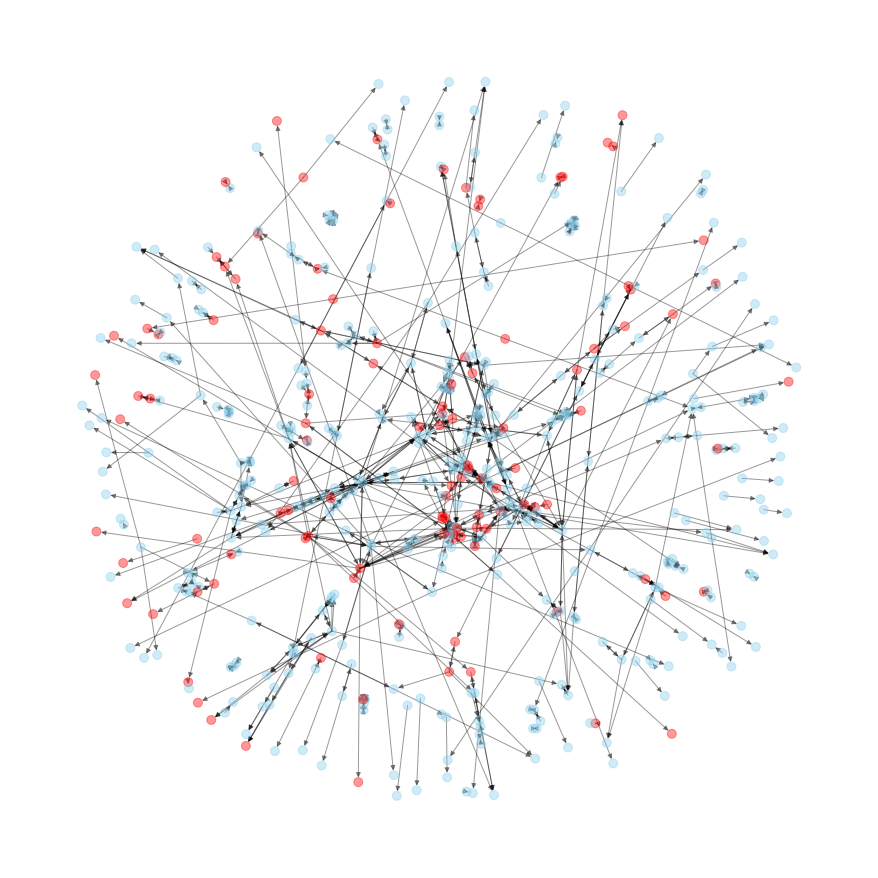

In [18]:
#visualize graph
plt.figure(figsize=(12,12))
nx.draw(G, node_size=80, alpha=0.4, arrows=True, node_color=colors)

In [19]:
# pos = nx.spring_layout(G)

# plt.figure(figsize=(12,12))
# nx.draw(G, 
#               pos = pos,
#               node_size = 60,
#               node_color = colors, with_labels=True)

In [20]:
# labels = [i for i in dict(G.nodes).keys()]
# labels = {i:i for i in dict(G.nodes).keys()}
# weights = [G[u][v]['weight'] for u,v in G.edges]

# #nx.draw(G, pos, edges=edges, edge_color=colors, width=weights)

# fig, ax = plt.subplots(figsize=(40,40))
# pos = nx.spring_layout(G)
# nx.draw_networkx_nodes(G, pos, ax = ax, labels=True, node_color=colors)
# nx.draw_networkx_edges(G, pos, width=weights, ax=ax)
# _ = nx.draw_networkx_labels(G, pos, labels, ax=ax)

### NetworkX Algorithms 

In [21]:
# calculate gender assortiativy
assort_gender = nx.attribute_assortativity_coefficient(G, 'gender')
assort_gender #returns how much influence gender has that a call is established

0.23126096277528754

In [22]:
nx.number_of_isolates(G) #number of isolates

0

In [23]:
# descending degree centrality ranking
a = nx.degree_centrality(G)
K = 7
rank = dict()
for key in a:
    # rounding to K using round()
    rank[key] = round(a[key], K)
sort = sorted(rank.items(), key = lambda x: x[1], reverse= True)

In [24]:
sort[0:10]

[(221, 0.0451866),
 (263, 0.0392927),
 (401, 0.0333988),
 (485, 0.0333988),
 (268, 0.0255403),
 (52, 0.0255403),
 (69, 0.0235756),
 (13, 0.0235756),
 (49, 0.021611),
 (4, 0.021611)]

In [25]:
# descending degree centrality ranking
b = nx.betweenness_centrality(G)
K = 7
rank = dict()
for key in b:
    # rounding to K using round()
    rank[key] = round(b[key], K)
sort2 = sorted(rank.items(), key = lambda x: x[1], reverse= True)

In [26]:
sort2[0:10]

[(263, 0.0598347),
 (221, 0.0512451),
 (268, 0.0444161),
 (69, 0.0427938),
 (52, 0.0308902),
 (485, 0.0305901),
 (401, 0.0283874),
 (472, 0.0251408),
 (36, 0.0229993),
 (301, 0.0195541)]

In [27]:
c = nx.pagerank(G, alpha=0.85) # page rank calculation -> directed networks
K = 7
rank = dict()
for key in c:
    # rounding to K using round()
    rank[key] = round(c[key], K)
sort4 = sorted(rank.items(), key = lambda x: x[1], reverse= True)

In [28]:
sort4

[(49, 0.0108336),
 (180, 0.0086783),
 (627, 0.0078571),
 (578, 0.0078482),
 (405, 0.0077116),
 (682, 0.0070281),
 (401, 0.0069443),
 (666, 0.0067244),
 (48, 0.0065492),
 (560, 0.0063356),
 (47, 0.0060428),
 (527, 0.0058238),
 (510, 0.005795),
 (441, 0.0057212),
 (470, 0.0056907),
 (208, 0.0055552),
 (354, 0.0054538),
 (291, 0.0054298),
 (158, 0.0053961),
 (395, 0.0053462),
 (478, 0.005335),
 (357, 0.0052995),
 (567, 0.0052837),
 (678, 0.0052388),
 (136, 0.0051932),
 (668, 0.0051897),
 (51, 0.0050227),
 (465, 0.005014),
 (94, 0.0049929),
 (480, 0.0049669),
 (283, 0.0048656),
 (572, 0.0048151),
 (218, 0.0048034),
 (561, 0.0047893),
 (252, 0.0047869),
 (699, 0.0047337),
 (3, 0.0047161),
 (459, 0.004709),
 (495, 0.0046851),
 (210, 0.0046802),
 (13, 0.0046597),
 (342, 0.0046516),
 (301, 0.0046105),
 (420, 0.0045928),
 (289, 0.0045875),
 (374, 0.0045508),
 (382, 0.0044873),
 (325, 0.0044859),
 (471, 0.0044242),
 (260, 0.0044076),
 (25, 0.0044024),
 (137, 0.0043519),
 (766, 0.004333),
 (491, 

In [29]:
print(nx.clustering(G)) #number of clusters 

{300: 0.05555555555555555, 301: 0.3333333333333333, 37: 0.2222222222222222, 69: 0.13114754098360656, 186: 0.5, 512: 0, 299: 0.1111111111111111, 133: 0.1111111111111111, 144: 0, 237: 1.0, 0: 0, 208: 0.14285714285714285, 36: 0, 221: 0.07056451612903226, 371: 0, 743: 0.3333333333333333, 268: 0.08333333333333333, 151: 0, 401: 0.12307692307692308, 457: 1.0, 263: 0.08064516129032258, 169: 0.5, 288: 0.175, 342: 0.25757575757575757, 720: 0, 190: 0.19318181818181818, 372: 0.7222222222222222, 290: 0, 678: 0, 96: 0.07692307692307693, 81: 0, 324: 0.1323529411764706, 598: 0.07142857142857142, 625: 0, 121: 0, 104: 0.16666666666666666, 666: 0, 354: 0, 19: 0, 47: 0.25, 449: 1.0, 46: 1.0, 595: 0, 531: 0.2, 687: 0.16666666666666666, 310: 0.5, 265: 0.5, 540: 0.5, 634: 0.5, 681: 0.15384615384615385, 677: 0.023809523809523808, 111: 0.125, 466: 0, 183: 0, 42: 0, 269: 0.2222222222222222, 267: 0.5, 543: 0, 412: 0, 173: 0.2222222222222222, 561: 0.3333333333333333, 631: 1.0, 689: 0, 225: 0.125, 574: 0, 337: 0, 

In [30]:
# calculating jaccard coefficident 
# preds = nx.jaccard_coefficient(G)
# for u, v, p in preds:
#     if p > 0.000: 
#         print(f"({u}, {v}) -> {p:.8f}")

In [31]:
#list(nx.enumerate_all_cliques(G))[-1] # listing cliques 

In [32]:
# # function for returning if clique exists with specific size 
# def find_cliques_size_k(G, k):
#     all_cliques = set()
#     for clique in nx.find_cliques(G):
#         if len(clique) == k:
#             all_cliques.add(tuple(sorted(clique)))
#         elif len(clique) > k:
#             for mini_clique in itertools.combinations(clique, k):
#                 all_cliques.add(tuple(sorted(mini_clique)))
#     return len(all_cliques)

In [33]:
#find_cliques_size_k(G, 5)

In [34]:
#G = nx.from_pandas_edgelist(df_call_with_gender, 'caller','callee', edge_attr='duration')

In [35]:
#G1 = nx.from_pandas_edgelist(df_call_with_gender.groupby([df_call_with_gender.caller, df_call_with_gender.callee]).sum().reset_index(), 'caller', 'callee', edge_attr=True)

In [36]:
# durations = [i['duration'] for i in dict(G.edges).values()]
# labels = [i for i in dict(G.nodes).keys()]
# labels = {i:i for i in dict(G.nodes).keys()}

# fig, ax = plt.subplots(figsize=(60,60))
# pos = nx.kamada_kawai_layout(G)
# nx.draw_networkx_nodes(G, pos, ax = ax, labels=True, node_color=colors)
# nx.draw_networkx_edges(G, pos, ax=ax)
# _ = nx.draw_networkx_labels(G, pos, labels, ax=ax)

In [37]:
# remove missed calls 
df_call_with_gender = df_call_with_gender[df_call_with_gender['duration'] != -1]

### Statistical analysis of call duration 

In [38]:
#display statistics for duration 
df_call_with_gender.duration.describe()

count    3036.000000
mean       64.138011
std       189.503059
min         0.000000
25%         2.000000
50%        16.000000
75%        58.000000
max      5138.000000
Name: duration, dtype: float64

In [39]:
#remove calls under 1 second
df_call_with_gender3 = df_call_with_gender[df_call_with_gender['duration'] > 1]

In [40]:
df_call_with_gender3.duration.describe()

count    2408.000000
mean       80.829319
std       209.603074
min         2.000000
25%         5.000000
50%        29.000000
75%        73.000000
max      5138.000000
Name: duration, dtype: float64

In [41]:
df_call_with_gender3.caller.nunique()

395

In [42]:
# define qunatiles 
low = .20
high = .95
quant_df = df_call_with_gender.duration.quantile([low, high])
print(quant_df)

0.20      1.00
0.95    249.25
Name: duration, dtype: float64


In [43]:
df_call_with_gender.duration.median()

16.0

In [44]:
df_men_only = df_call_with_gender[(df_call_with_gender['female_caller'] == 0) & (df_call_with_gender['female_callee'] == 0)]

In [45]:
df_men_only['duration'].std()

143.2438228956874

In [46]:
df_men_only['duration'].mean()

54.42504307869041

In [47]:
df_mix_1 = df_call_with_gender[(df_call_with_gender['female_caller'] == 1) & (df_call_with_gender['female_callee'] == 0)]

In [48]:
df_mix_1['duration'].std()

137.0590789093582

In [49]:
df_mix_1['duration'].mean()

58.23463687150838

In [50]:
df_mix_2 = df_call_with_gender[(df_call_with_gender['female_caller'] == 0) & (df_call_with_gender['female_callee'] == 1)]

In [51]:
df_mix_2['duration'].std()

330.88544570475443

In [52]:
df_mix_2['duration'].mean()

106.81453154875717

In [53]:
df_women_only = df_call_with_gender[(df_call_with_gender['female_caller'] == 1) & (df_call_with_gender['female_callee'] == 1)]

In [54]:
df_women_only['duration'].std()

144.87639858662422

In [55]:
df_women_only['duration'].mean()

54.60851063829787

In [56]:
#remove outliers 
def remove_outlier(df, col):
  q1 = df_call_with_gender.duration.quantile(0.20)
  q3 = df_call_with_gender.duration.quantile(0.95)

  iqr = q3 - q1
  lower_bound  = q1 - (1.5  * iqr)
  upper_bound = q3 + (1.5 * iqr)

  out_df = df_call_with_gender.loc[(df_call_with_gender.duration > lower_bound) & (df_call_with_gender.duration < upper_bound)]
  return out_df

In [57]:
df_without_outlier= remove_outlier(df_call_with_gender, df_call_with_gender.duration)

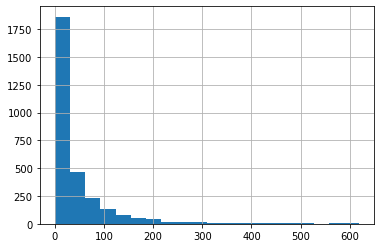

In [58]:
#check data distribution 
df_without_outlier.duration.hist(bins=20)

In [75]:
df_without_outlier.describe()

,timestamp,caller,callee,duration,female_caller,female_callee,weight
count,2.983000e+03,2983.000000,2983.000000,2983.000000,2983.000000,2983.000000,2983.000000
mean,1.289051e+06,341.031512,356.958766,45.379149,0.254107,0.246396,14.320818
std,6.701774e+05,223.229866,223.091995,79.449363,0.435431,0.430984,18.427282
min,1.840000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,7.499560e+05,136.000000,170.000000,2.000000,0.000000,0.000000,3.000000
50%,1.272275e+06,311.000000,357.000000,15.000000,0.000000,0.000000,7.000000
75%,1.856148e+06,551.000000,560.000000,54.000000,1.000000,0.000000,18.000000
max,2.416399e+06,846.000000,845.000000,619.000000,1.000000,1.000000,88.000000


In [59]:
df_men_only1 = df_without_outlier[(df_without_outlier['female_caller'] == 0) & (df_without_outlier['female_callee'] == 0)]

In [60]:
df_men_only1['duration'].std()

70.59710476843709

In [61]:
df_men_only1['duration'].mean()

42.22732558139535

In [62]:
df_mix_new1 = df_without_outlier[(df_without_outlier['female_caller'] == 0) & (df_without_outlier['female_callee'] == 1)]

In [63]:
df_mix_new1['duration'].std()

105.28406423571268

In [64]:
df_mix_new1['duration'].mean()

61.16633663366336

In [65]:
df_mix_new2 = df_without_outlier[(df_without_outlier['female_caller'] == 1) & (df_without_outlier['female_callee'] == 0)]

In [66]:
df_mix_new2['duration'].std()

82.53611324796582

In [67]:
df_mix_new2['duration'].mean()

44.71022727272727

In [68]:
df_women_only1 = df_without_outlier[(df_without_outlier['female_caller'] == 1) & (df_without_outlier['female_callee'] == 1)]

In [69]:
df_women_only1['duration'].std()

63.19843605743991

In [70]:
df_women_only1['duration'].mean()

35.821739130434786

### Just for fun... 

In [71]:
# Trying out numpy matrix 
friendship = nx.from_pandas_edgelist(df_call_with_gender,
                                    'caller','callee', create_using=nx.MultiGraph()) #, edge_attr='duration')

In [72]:
F = nx.to_numpy_matrix(friendship, multigraph_weight=sum)
print(F) #numpy matrix

[[ 0. 53.  0. ...  0.  0.  0.]
 [53.  0. 23. ...  0.  0.  0.]
 [ 0. 23.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  2.]
 [ 0.  0.  0. ...  0.  2.  0.]]


In [73]:
temp = nx.MultiGraph()
friendship_multi = nx.from_numpy_matrix(F, parallel_edges=True, create_using=temp)

In [74]:
friendship_multi.edges(data=True)

MultiEdgeDataView([(0, 1, {'weight': 53.0}), (0, 13, {'weight': 1.0}), (0, 14, {'weight': 1.0}), (0, 15, {'weight': 1.0}), (1, 2, {'weight': 23.0}), (1, 3, {'weight': 6.0}), (1, 4, {'weight': 2.0}), (2, 3, {'weight': 11.0}), (2, 12, {'weight': 35.0}), (2, 224, {'weight': 1.0}), (3, 4, {'weight': 3.0}), (3, 7, {'weight': 2.0}), (3, 16, {'weight': 3.0}), (3, 17, {'weight': 3.0}), (3, 20, {'weight': 1.0}), (4, 219, {'weight': 1.0}), (5, 6, {'weight': 1.0}), (5, 10, {'weight': 5.0}), (5, 12, {'weight': 7.0}), (6, 7, {'weight': 2.0}), (6, 8, {'weight': 2.0}), (6, 9, {'weight': 14.0}), (7, 9, {'weight': 1.0}), (7, 202, {'weight': 8.0}), (8, 199, {'weight': 31.0}), (8, 209, {'weight': 1.0}), (10, 11, {'weight': 4.0}), (11, 180, {'weight': 2.0}), (11, 185, {'weight': 2.0}), (11, 191, {'weight': 20.0}), (11, 192, {'weight': 1.0}), (11, 193, {'weight': 2.0}), (11, 194, {'weight': 1.0}), (12, 18, {'weight': 2.0}), (12, 275, {'weight': 1.0}), (13, 15, {'weight': 1.0}), (13, 20, {'weight': 7.0}), (